In [3]:
# Load and inspect dataset

import pandas as pd

# Load the dataset (make sure spambase.csv is in the same folder as your notebook)
df = pd.read_csv("spambase.csv")

# Shape (rows, columns)
print("Dataset Shape:", df.shape)

# Show first 5 rows to verify columns
print("\nFirst 5 rows:")
print(df.head())

# Identify target column (commonly last column in Spambase)
target_col = df.columns[-1]
print("\nTarget column detected:", target_col)

# Check missing values
print("\nMissing values per column:")
print(df.isna().sum().sum(), "total missing values")

# Check duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

# Class distribution
print("\nClass distribution (target counts):")
print(df[target_col].value_counts())
print("\nClass distribution (proportion):")
print(df[target_col].value_counts(normalize=True))


Dataset Shape: (4601, 58)

First 5 rows:
   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0            0.00               0.64           0.64           0.0   
1            0.21               0.28           0.50           0.0   
2            0.06               0.00           0.71           0.0   
3            0.00               0.00           0.00           0.0   
4            0.00               0.00           0.00           0.0   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0           0.32            0.00              0.00                0.00   
1           0.14            0.28              0.21                0.07   
2           1.23            0.19              0.19                0.12   
3           0.63            0.00              0.31                0.63   
4           0.63            0.00              0.31                0.63   

   word_freq_order  word_freq_mail  ...  char_freq_;  char_freq_(  \
0             0.00            

In [5]:
# Drop duplicates & basic checks
import pandas as pd
import numpy as np

assert 'df' in globals(), "Run Cell 1 first to create `df`."

target_col = 'is_spam'
assert target_col in df.columns, f"`{target_col}` not found."

before = len(df)
df_clean = df.drop_duplicates().reset_index(drop=True)
after = len(df_clean)
print(f"Duplicates dropped: {before - after} (from {before} → {after})")

y = df_clean[target_col].astype(int)
X = df_clean.drop(columns=[target_col])

print("Unique target values:", sorted(y.unique()))
assert set(y.unique()) <= {0,1}, "Target must be binary 0/1."

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
non_numeric = [c for c in X.columns if c not in num_cols]
print("Non-numeric predictor columns:", non_numeric if non_numeric else "None")

print("Any missing values in predictors?:", X[num_cols].isna().any().any())

Duplicates dropped: 391 (from 4601 → 4210)
Unique target values: [0, 1]
Non-numeric predictor columns: None
Any missing values in predictors?: False


In [7]:
# Impute numeric (median) & standardize (z-score)
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

imp = SimpleImputer(strategy="median")
X_imp = pd.DataFrame(imp.fit_transform(X[num_cols]), columns=num_cols)

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imp), columns=num_cols)

# Optional: tidy column names
X_scaled.columns = [c.strip().lower().replace(" ", "_") for c in X_scaled.columns]

print("Scaled features shape:", X_scaled.shape)
print(X_scaled.head())

Scaled features shape: (4210, 57)
   word_freq_make  word_freq_address  word_freq_all  word_freq_3d  \
0       -0.347922           1.161025       0.675889     -0.046644   
1        0.352150           0.368433       0.404391     -0.046644   
2       -0.147901          -0.248027       0.811639     -0.046644   
3       -0.347922          -0.248027      -0.565245     -0.046644   
4       -0.347922          -0.248027      -0.565245     -0.046644   

   word_freq_our  word_freq_over  word_freq_remove  word_freq_internet  \
0      -0.007737       -0.350205         -0.295731           -0.263265   
1      -0.269470        0.664297          0.232922           -0.092630   
2       1.315470        0.338207          0.182574            0.029252   
3       0.443026       -0.350205          0.484661            1.272445   
4       0.443026       -0.350205          0.484661            1.272445   

   word_freq_order  word_freq_mail  ...  word_freq_conference  char_freq_;  \
0        -0.325617       -0.

In [9]:
# Class balance + save model-ready dataset
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

counts = y.value_counts().sort_index()
ratios = (counts / len(y)).round(4)
print("Class counts:\n", counts)
print("Class ratios:\n", ratios)

class_wts = compute_class_weight(class_weight='balanced',
                                 classes=np.array([0,1]),
                                 y=y.values)
print("Suggested class_weight:", {0: class_wts[0], 1: class_wts[1]})

model_ready = X_scaled.copy()
model_ready['is_spam'] = y.values
model_ready.to_csv("spambase_model_ready.csv", index=False)
print("Saved: spambase_model_ready.csv | Shape:", model_ready.shape)

Class counts:
 0    2531
1    1679
Name: is_spam, dtype: int64
Class ratios:
 0    0.6012
1    0.3988
Name: is_spam, dtype: float64
Suggested class_weight: {0: 0.8316870802054523, 1: 1.2537224538415723}
Saved: spambase_model_ready.csv | Shape: (4210, 58)


In [11]:
# Correlation of features with target (absolute Pearson)

import numpy as np
import pandas as pd

# Calculate correlation between each feature and target
corrs = {}
for c in X_scaled.columns:
    corrs[c] = np.corrcoef(X_scaled[c], y)[0, 1]

# Sort by absolute correlation
corr_series = pd.Series(corrs).abs().sort_values(ascending=False)

print("Top 12 Features by |Correlation| with Target:\n")
print(corr_series.head(12))

Top 12 Features by |Correlation| with Target:

word_freq_your              0.394392
word_freq_remove            0.334456
char_freq_$                 0.326603
word_freq_000               0.325716
word_freq_free              0.279261
word_freq_receive           0.272451
word_freq_hp                0.270024
word_freq_business          0.260773
word_freq_you               0.256242
word_freq_hpl               0.242411
char_freq_!                 0.233812
capital_run_length_total    0.231671
dtype: float64


In [13]:
# Mutual Information with target
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X_scaled, y, random_state=0, discrete_features=False)
mi_series = pd.Series(mi, index=X_scaled.columns).sort_values(ascending=False)

print("Top 12 Features by Mutual Information:\n")
print(mi_series.head(12))

Top 12 Features by Mutual Information:

char_freq_!                   0.197692
char_freq_$                   0.172626
capital_run_length_longest    0.161725
capital_run_length_average    0.147483
word_freq_remove              0.142553
word_freq_your                0.131988
word_freq_free                0.121150
word_freq_hp                  0.115637
word_freq_money               0.109167
capital_run_length_total      0.108147
word_freq_our                 0.098141
word_freq_000                 0.094880
dtype: float64


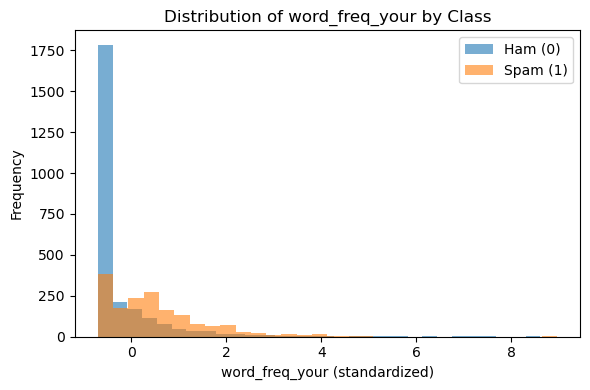

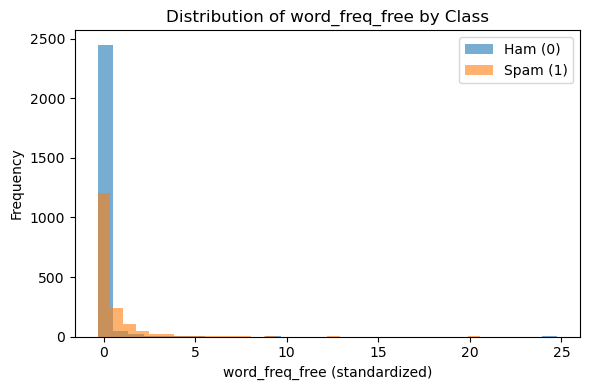

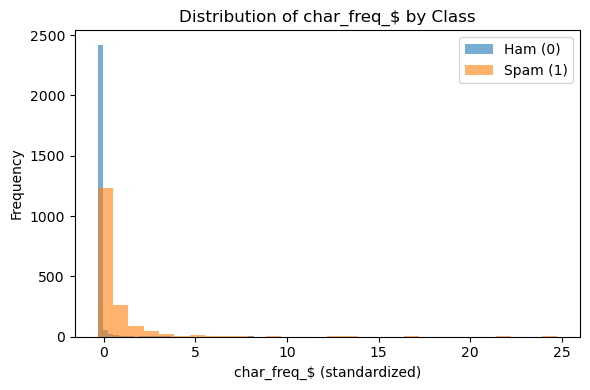

In [15]:
# Histograms of top predictors by class
import matplotlib.pyplot as plt

top_features = ["word_freq_your", "word_freq_free", "char_freq_$"]

for feat in top_features:
    plt.figure(figsize=(6,4))
    plt.hist(X_scaled.loc[y==0, feat], bins=30, alpha=0.6, label="Ham (0)")
    plt.hist(X_scaled.loc[y==1, feat], bins=30, alpha=0.6, label="Spam (1)")
    plt.title(f"Distribution of {feat} by Class")
    plt.xlabel(f"{feat} (standardized)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

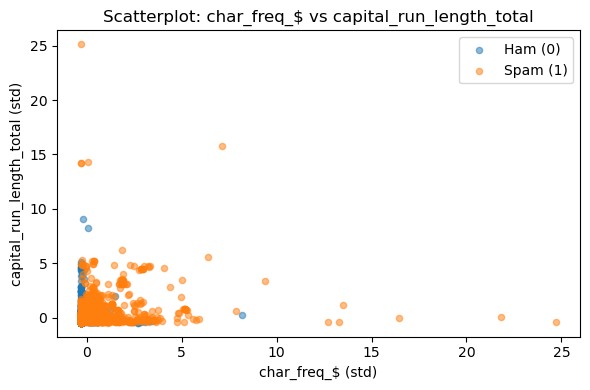

In [17]:
# Scatterplot of two strong predictors
f1, f2 = "char_freq_$", "capital_run_length_total"

plt.figure(figsize=(6,4))
plt.scatter(X_scaled.loc[y==0, f1], X_scaled.loc[y==0, f2],
            alpha=0.5, label="Ham (0)", s=20)
plt.scatter(X_scaled.loc[y==1, f1], X_scaled.loc[y==1, f2],
            alpha=0.5, label="Spam (1)", s=20)
plt.xlabel(f1 + " (std)")
plt.ylabel(f2 + " (std)")
plt.title(f"Scatterplot: {f1} vs {f2}")
plt.legend()
plt.tight_layout()
plt.show()

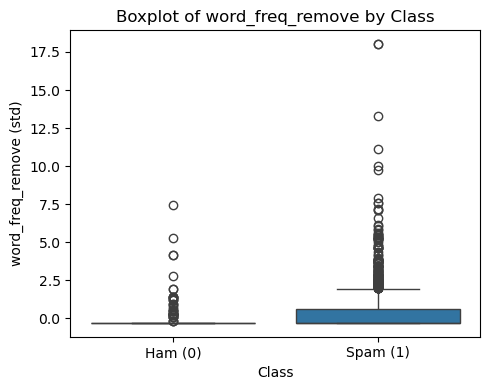

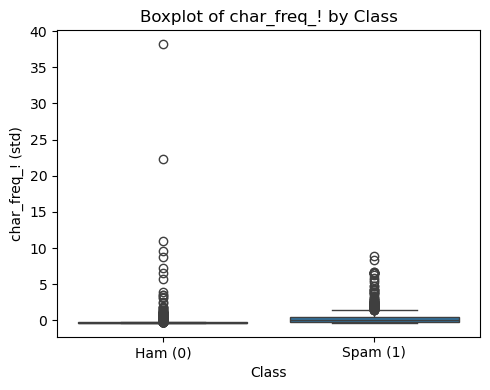

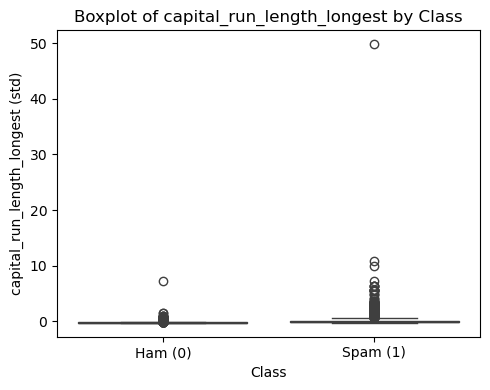

In [19]:
# Boxplots of selected predictors by class
import seaborn as sns

box_features = ["word_freq_remove", "char_freq_!", "capital_run_length_longest"]

for feat in box_features:
    plt.figure(figsize=(5,4))
    sns.boxplot(x=y, y=X_scaled[feat])
    plt.xticks([0,1], ["Ham (0)", "Spam (1)"])
    plt.title(f"Boxplot of {feat} by Class")
    plt.xlabel("Class")
    plt.ylabel(feat + " (std)")
    plt.tight_layout()
    plt.show()

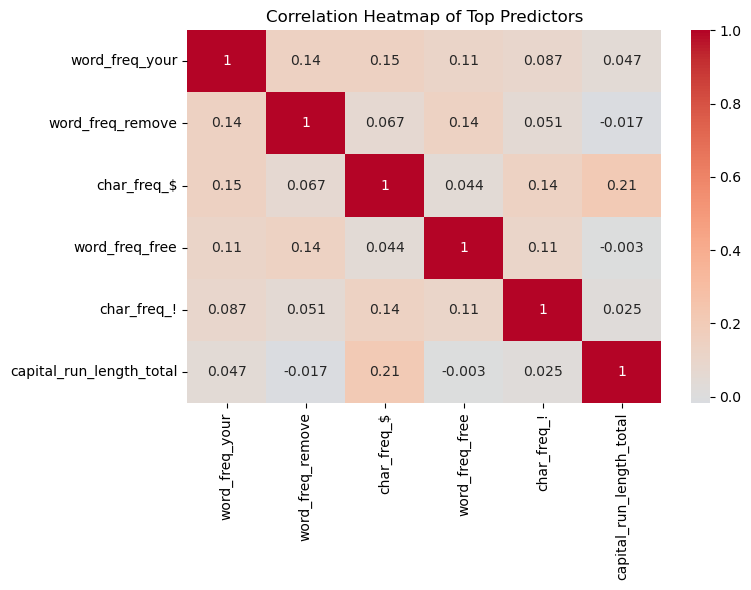

In [21]:
# Correlation heatmap of top predictors
import seaborn as sns

heatmap_features = ["word_freq_your", "word_freq_remove", "char_freq_$",
                    "word_freq_free", "char_freq_!", "capital_run_length_total"]

plt.figure(figsize=(8,6))
sns.heatmap(X_scaled[heatmap_features].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Top Predictors")
plt.tight_layout()
plt.show()